In [160]:
import json
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader, Batch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import jsonlines
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import copy

In [166]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

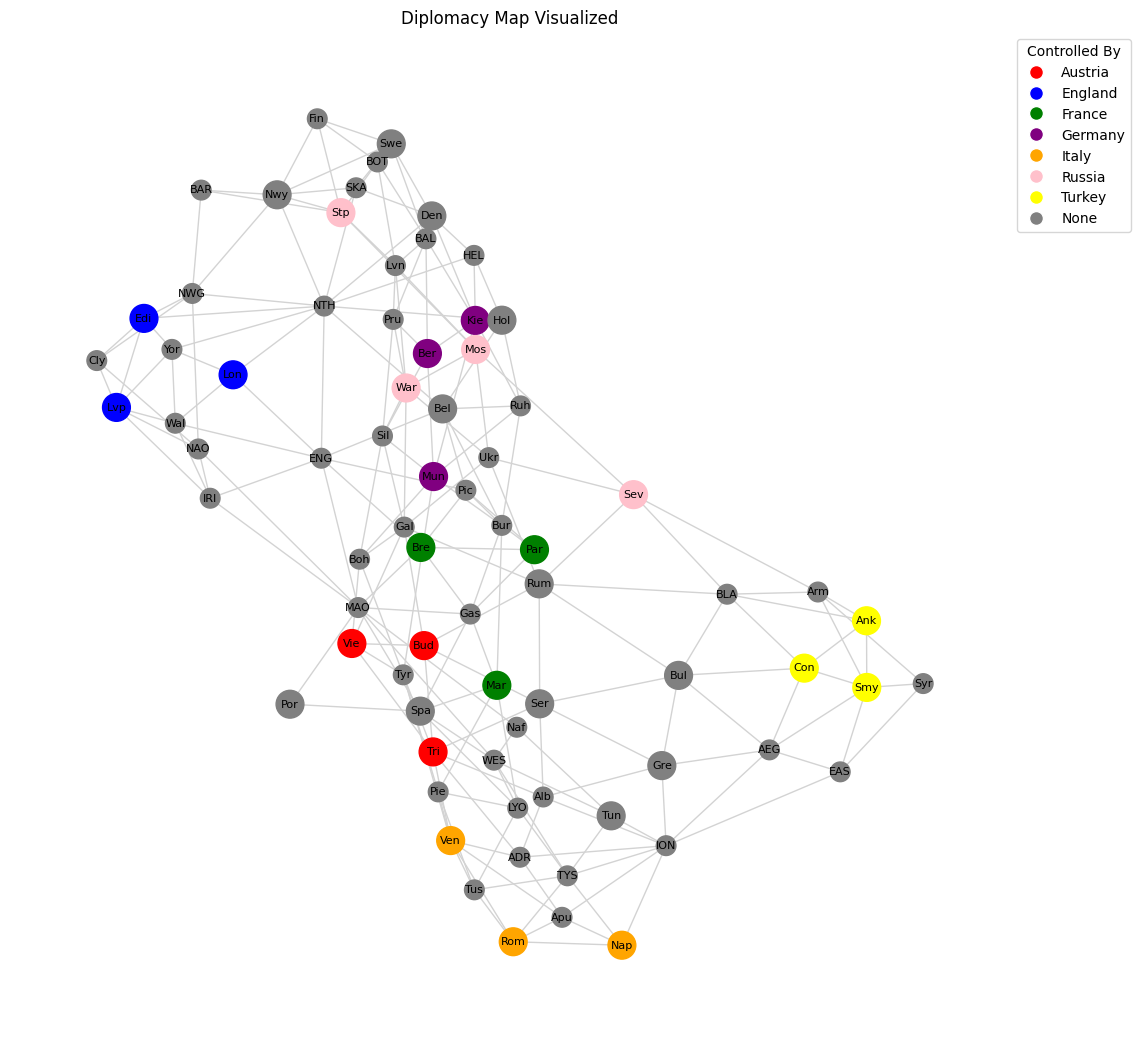

In [152]:
def visualize_map(data):
    arr = list(data.keys())
    G = nx.Graph()
    for i, province in enumerate(data):
        G.add_node(i,
                   label=province,
                   type=data[province]["provinceType"],
                    controlledBy=data[province]["controlledBy"],
                    unitType=data[province]["unitType"],
                    supplyCentre=data[province]["supplyCentre"])
        for adj in data[province]["adjacency"]:
            G.add_edge(i, arr.index(adj))
    pos = nx.spring_layout(G, seed=42)
    node_colors = []
    colors = {
        "Austria": "red",
        "England": "blue",
        "France": "green",
        "Germany": "purple",
        "Italy": "orange",
        "Russia": "pink",
        "Turkey": "yellow",
        "None": "grey"
    }
    for node in G.nodes():
        node_colors.append(colors[G.nodes[node]["controlledBy"]])
    node_sizes = [400 if G.nodes[node]["supplyCentre"] else 200 for node in G.nodes()]
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, labels={n: G.nodes[n]["label"] for n in G.nodes()}, node_color=node_colors, node_size=node_sizes, font_size=8, font_color="black", edge_color="lightgrey")
    plt.title("Diplomacy Map Visualized")
    legend_labels = {v: k for k, v in colors.items()}
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[k], markerfacecolor=k, markersize=10) for k in legend_labels.keys()]
    plt.legend(handles=handles, title="Controlled By", loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
with open("map.json", 'r') as f:
    data = json.load(f)
visualize_map(data)

In [153]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, maps, map_to_idx):
        self.maps = maps
        self.map_to_idx = map_to_idx
        data = maps[0]
        self.provinces = list(data.keys())
        self.countries = ["Austria", "England", "France", "Germany", "Italy", "Russia", "Turkey", "None"]
        self.province_types = ["Inland", "Coastal", "Water"]
        self.unit_types = ["A", "F", "None"]
        
    def __len__(self):
        return len(self.maps)
    
    def one_hot_encode(self, value, categories):
        one_hot = np.zeros(len(categories))
        one_hot[categories.index(value)] = 1
        return one_hot
    
    def __getitem__(self, idx):
        data = self.maps[idx]
        features = []
        edges = []
        for province, info in data.items():
            country = self.one_hot_encode(info["controlledBy"], self.countries)
            province_type = self.one_hot_encode(info["provinceType"], self.province_types)
            unit_type = self.one_hot_encode(info["unitType"], self.unit_types)
            supply_centre = [0, 1] if info["supplyCentre"] else [1, 0]
            controlledBy = self.one_hot_encode(info["controlledBy"], self.countries)
            currentControl = self.one_hot_encode(info["currentControl"], self.countries)
            feature_vector = np.concatenate([country, province_type, unit_type, supply_centre, controlledBy, currentControl])
            features.append(feature_vector)
            for adj in info["adjacency"]:
                edges.append((self.provinces.index(province), self.provinces.index(adj)))
        features = torch.tensor(features, dtype=torch.float)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        data = Data(x=features, edge_index=edge_index)
        return data

In [154]:
class DiplomacyVocabulary(Dataset):
    def __init__(self):
        # Initialize the vocabulary with special tokens
        self.word2idx = {"PAD": 0, "UNK": 1}
        self.idx2word = {0: "PAD", 1: "UNK"}
        
    def add_token(self, token):
        # Add a new token to the vocabulary
        if token not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[token] = idx
            self.idx2word[idx] = token
        
    def __len__(self):
        return len(self.word2idx)
    
    def tokenize(self, message):
        message = message.lower()
        tokens = word_tokenize(message)
        return [self.word2idx.get(token, 1) for token in tokens]

In [155]:
class DiplomacyDataset(Dataset):
    def __init__(self, file_path, maps, maps_to_idx, vocab=None, construct=False):
        self.data = []
        self.vocab = vocab if vocab else DiplomacyVocabulary()
        self.maps = maps
        self.maps_to_idx = maps_to_idx
        self.map_dataset = MapDataset(maps, maps_to_idx)
        
        with jsonlines.open(file_path, 'r') as f:
            for line in f:
                for i, message in enumerate(line['messages']):
                    # Ignore messages with no sender labels
                    if line['sender_labels'][i] == 'NOANNOTATION':
                        continue
                    game_id = line['game_id']
                    year = line['years'][i]
                    season = line['seasons'][i].lower()
                    map_idx = self.maps_to_idx[f"DiplomacyGame{game_id}_{year}_{season}"]
                    self.data.append({
                        'message': message,
                        'label': 1 if line['sender_labels'][i] else 0, # 1 for True, 0 for False message
                        'sender': line['speakers'][i].capitalize(),
                        'receiver': line['receivers'][i].capitalize(),
                        'map_idx': map_idx
                    })
                    
                    if construct:
                        tokens = word_tokenize(message)
                        for token in tokens:
                            self.vocab.add_token(token)
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.vocab.tokenize(self.data[idx]['message'])
        
        return {
            'tokens': torch.tensor(tokens, dtype=torch.long),
            'label': torch.tensor(self.data[idx]['label'], dtype=torch.long),
            'map': self.map_dataset[self.data[idx]['map_idx']],
            'receiver': self.map_dataset.one_hot_encode(self.data[idx]['receiver'], self.map_dataset.countries),
            'sender': self.map_dataset.one_hot_encode(self.data[idx]['sender'], self.map_dataset.countries)
        }

In [156]:
def collate_fn(batch):
    batch = sorted(batch, key=lambda x: len(x['tokens']), reverse=True)
    
    tokens = pad_sequence([item['tokens'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.stack([item['label'] for item in batch])
    map = [item['map'] for item in batch]
    receiver = torch.tensor([item['receiver'] for item in batch], dtype=torch.float)
    sender = torch.tensor([item['sender'] for item in batch], dtype=torch.float)
    
    return {
        'tokens': tokens,
        'labels': labels,
        'maps': map,
        'receivers': receiver,
        'senders': sender
    }

In [157]:
maps = []
maps_to_idx = {}
for FILE in os.listdir('moves_map'):
    with open(os.path.join('moves_map', FILE), 'r') as f:
        data = json.load(f)
        maps.append(data)
        maps_to_idx[f"{FILE.split('.')[0]}"] = len(maps) - 1
        
train_dataset = DiplomacyDataset(f'data/train.jsonl', maps, maps_to_idx, construct=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
vocab = train_dataset.vocab

val_dataset = DiplomacyDataset(f'data/validation.jsonl', maps, maps_to_idx, vocab=vocab)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

test_dataset = DiplomacyDataset(f'data/test.jsonl', maps, maps_to_idx, vocab=vocab)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [158]:
print(train_dataset[0])

{'tokens': tensor([2315,    3,  161,    5,    6, 1264,    8,    9,   10,   11,   12, 1264,
          13,   14,   15,   16,   17,   18, 1264,   19,   20,   21,   22,    9,
          23,   11,    1,   25,   26, 1264,   19,   20,   27,   28,   29,    5,
          30,   31,    9,   23,   32,   12,   59,   25,   34,   19,   35,   36,
          25,   32,   37,   38,   39,   40,   41,   42,   12,  125,   44,   45,
        1264,   46,   32,   47, 1264,   19,   48,   49,   18,   50,   51,   14,
          52,   53,   54,   25,   55,   14,   56,   57,   58,   25,   59,   60,
          61,   59,   62,   63,   64,   37,   38,   32,   65,   66,   47,   18,
          19,   35,   68,   69,   70,   12,   34,   51,   72,   73,   74,   75,
          62,   59,   16,   47]), 'label': tensor(1), 'map': Data(x=[75, 32], edge_index=[2, 412]), 'receiver': array([0., 0., 0., 1., 0., 0., 0., 0.]), 'sender': array([0., 0., 0., 0., 1., 0., 0., 0.])}


In [159]:
embedding_path = "embeddings/glove.twitter.27B.200d.txt"
pretrained_embedding = np.zeros((len(vocab), 200))
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in vocab.word2idx:
            index = vocab.word2idx[word]
            vector = np.array(values[1:], dtype='float32')
            pretrained_embedding[index] = vector

In [202]:
class DeceptionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, lst_num_layers, map_input_dim, map_hidden_dim, map_output_dim, country_dim, classifier_hidden_dim, pretrained_embedding=None):
        super(DeceptionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embedding is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embedding))
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden_dim, lst_num_layers, batch_first=True, bidirectional=True)
        self.sr_proj = nn.Linear(2 * country_dim, lstm_hidden_dim * 2)
        
        self.gan1 = GATConv(map_input_dim, map_hidden_dim, heads=4, dropout=0.2)
        self.gan2 = GATConv(4*map_hidden_dim, map_output_dim, heads=4, dropout=0.2)
        self.map_proj = nn.Sequential(
            nn.Linear(4*map_output_dim, map_hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(map_hidden_dim)
        )
        
        self.map_attn_proj = nn.Linear(map_hidden_dim, lstm_hidden_dim * 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, classifier_hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_hidden_dim, classifier_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(classifier_hidden_dim // 2, 1)
        )
        
    def forward(self, tokens, maps, senders, receivers):
        embedded = self.embedding(tokens)
        lengths = (tokens != 0).sum(dim=1)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        rnn_out, _ = self.lstm(packed_embedded)
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        
        batch = Batch.from_data_list(maps)
        x = F.relu(self.gan1(batch.x, batch.edge_index))
        x = F.relu(self.gan2(x, batch.edge_index))
        map_rep = global_mean_pool(x, batch.batch)
        map_rep = self.map_proj(map_rep)
        query = self.map_attn_proj(map_rep).unsqueeze(1)
        
        sr = torch.cat([senders, receivers], dim=1)
        sr_proj = self.sr_proj(sr)
        key = torch.cat([rnn_out, sr_proj.unsqueeze(1)], dim=1)
        
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, key).squeeze(1)
        logits = self.classifier(attn_output)
        return logits.squeeze(1)

In [207]:
model = DeceptionModel(
    vocab_size=len(vocab),
    embedding_dim=200,
    lstm_hidden_dim=128,
    lst_num_layers=2,
    map_input_dim=32,
    map_hidden_dim=32,
    map_output_dim=16,
    country_dim=len(train_dataset.map_dataset.countries),
    classifier_hidden_dim=128,
    pretrained_embedding=pretrained_embedding
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criteria = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0/30.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.003)

EPOCHS = 30
PATIENCE = 5

patience_counter = 0
best_f1 = 0.0
best_model = None

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        tokens = batch['tokens'].to(device)
        labels = batch['labels'].float().to(device)
        maps = batch['maps']
        senders = batch['senders'].to(device)
        receivers = batch['receivers'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(tokens, maps, senders, receivers)
        logits = logits.view(-1)
        
        loss = criteria(logits, labels)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f'Epoch: {epoch+1}/{EPOCHS}')
    print(f'Train Loss: {total_loss/len(train_loader)}')
    
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            tokens = batch['tokens'].to(device)
            labels = batch['labels'].float().to(device)
            maps = batch['maps']
            senders = batch['senders'].to(device)
            receivers = batch['receivers'].to(device)
            
            logits = model(tokens, maps, senders, receivers)
            preds = (logits > 0.5).float()
            
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    f1 = f1_score(val_labels, val_preds, average='macro')
    weighted_f1 = f1_score(val_labels, val_preds, average='weighted')
    accuracy = accuracy_score(val_labels, val_preds)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        
    print(f'Validation Macro F1: {f1}')
    print(f'Validation Weighted F1: {weighted_f1}')
    print(f'Validation Accuracy: {accuracy}')
        
    # if patience_counter >= PATIENCE:
    #     print(f'Early stopping at epoch {epoch+1}')
    #     break
    
torch.save(best_model, 'model.pth')

100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 1/30
Train Loss: 0.05371660319521769
Validation Macro F1: 0.03804347826086957
Validation Weighted F1: 0.0030090886760009827
Validation Accuracy: 0.03954802259887006


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 2/30
Train Loss: 0.051326548123229156
Validation Macro F1: 0.03804347826086957
Validation Weighted F1: 0.0030090886760009827
Validation Accuracy: 0.03954802259887006


100%|██████████| 411/411 [02:08<00:00,  3.19it/s]


Epoch: 3/30
Train Loss: 0.049944825615471006
Validation Macro F1: 0.03804347826086957
Validation Weighted F1: 0.0030090886760009827
Validation Accuracy: 0.03954802259887006


100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 4/30
Train Loss: 0.04951154182771551
Validation Macro F1: 0.03804347826086957
Validation Weighted F1: 0.0030090886760009827
Validation Accuracy: 0.03954802259887006


100%|██████████| 411/411 [02:09<00:00,  3.17it/s]


Epoch: 5/30
Train Loss: 0.04720608052092892
Validation Macro F1: 0.06698569605118836
Validation Weighted F1: 0.057883825686850014
Validation Accuracy: 0.067090395480226


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 6/30
Train Loss: 0.04436296864056964
Validation Macro F1: 0.285928856332395
Validation Weighted F1: 0.47447541122416764
Validation Accuracy: 0.3446327683615819


100%|██████████| 411/411 [02:08<00:00,  3.19it/s]


Epoch: 7/30
Train Loss: 0.0412320304172535
Validation Macro F1: 0.45319807533176004
Validation Weighted F1: 0.7835652074088194
Validation Accuracy: 0.6885593220338984


100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 8/30
Train Loss: 0.03665568274185243
Validation Macro F1: 0.42392352665045024
Validation Weighted F1: 0.7139062903467296
Validation Accuracy: 0.596045197740113


100%|██████████| 411/411 [02:09<00:00,  3.18it/s]


Epoch: 9/30
Train Loss: 0.03008439413604945
Validation Macro F1: 0.42549059533976213
Validation Weighted F1: 0.7356081276440313
Validation Accuracy: 0.6228813559322034


100%|██████████| 411/411 [02:08<00:00,  3.19it/s]


Epoch: 10/30
Train Loss: 0.025401360432361308
Validation Macro F1: 0.49542451312761376
Validation Weighted F1: 0.8544246007862433
Validation Accuracy: 0.7966101694915254


100%|██████████| 411/411 [02:09<00:00,  3.18it/s]


Epoch: 11/30
Train Loss: 0.020569501133123527
Validation Macro F1: 0.4740252565695808
Validation Weighted F1: 0.8253319453603003
Validation Accuracy: 0.7507062146892656


100%|██████████| 411/411 [02:07<00:00,  3.21it/s]


Epoch: 12/30
Train Loss: 0.01783749949608515
Validation Macro F1: 0.49808544220801204
Validation Weighted F1: 0.8809797315855468
Validation Accuracy: 0.8425141242937854


100%|██████████| 411/411 [02:07<00:00,  3.22it/s]


Epoch: 13/30
Train Loss: 0.01596362337412272
Validation Macro F1: 0.47207444861326847
Validation Weighted F1: 0.8349842972118965
Validation Accuracy: 0.7662429378531074


100%|██████████| 411/411 [02:07<00:00,  3.23it/s]


Epoch: 14/30
Train Loss: 0.009756486964867498
Validation Macro F1: 0.479734735548689
Validation Weighted F1: 0.8715528183403626
Validation Accuracy: 0.827683615819209


100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 15/30
Train Loss: 0.011819059154984072
Validation Macro F1: 0.47688490993420346
Validation Weighted F1: 0.8592820574697725
Validation Accuracy: 0.806497175141243


100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 16/30
Train Loss: 0.009497774342465024
Validation Macro F1: 0.5058570539301681
Validation Weighted F1: 0.8818585271856888
Validation Accuracy: 0.8432203389830508


100%|██████████| 411/411 [02:07<00:00,  3.23it/s]


Epoch: 17/30
Train Loss: 0.007225074257498121
Validation Macro F1: 0.49480860347002076
Validation Weighted F1: 0.9058299145580608
Validation Accuracy: 0.8891242937853108


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 18/30
Train Loss: 0.006246365059114108
Validation Macro F1: 0.49768544002851917
Validation Weighted F1: 0.8887252757661569
Validation Accuracy: 0.856638418079096


100%|██████████| 411/411 [02:07<00:00,  3.21it/s]


Epoch: 19/30
Train Loss: 0.00773318499586224
Validation Macro F1: 0.4708731817522143
Validation Weighted F1: 0.836673537137702
Validation Accuracy: 0.7690677966101694


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 20/30
Train Loss: 0.0074974843521304225
Validation Macro F1: 0.4958369851007888
Validation Weighted F1: 0.8866763717028873
Validation Accuracy: 0.8531073446327684


100%|██████████| 411/411 [02:07<00:00,  3.23it/s]


Epoch: 21/30
Train Loss: 0.008226372817912605
Validation Macro F1: 0.5324081522061251
Validation Weighted F1: 0.908885335222329
Validation Accuracy: 0.8898305084745762


100%|██████████| 411/411 [02:08<00:00,  3.20it/s]


Epoch: 22/30
Train Loss: 0.007938529433111779
Validation Macro F1: 0.4982511135700109
Validation Weighted F1: 0.9038610920671447
Validation Accuracy: 0.8848870056497176


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 23/30
Train Loss: 0.008639991456552674
Validation Macro F1: 0.5055324276950044
Validation Weighted F1: 0.8888556722470624
Validation Accuracy: 0.8559322033898306


100%|██████████| 411/411 [02:07<00:00,  3.22it/s]


Epoch: 24/30
Train Loss: 0.005842298402664407
Validation Macro F1: 0.5084290830884906
Validation Weighted F1: 0.9042127883106535
Validation Accuracy: 0.884180790960452


100%|██████████| 411/411 [02:10<00:00,  3.15it/s]


Epoch: 25/30
Train Loss: 0.0038000620854137107
Validation Macro F1: 0.49991510401456135
Validation Weighted F1: 0.8869425676835883
Validation Accuracy: 0.8531073446327684


100%|██████████| 411/411 [02:07<00:00,  3.23it/s]


Epoch: 26/30
Train Loss: 0.004549199803517509
Validation Macro F1: 0.4934395740889285
Validation Weighted F1: 0.9042569427055072
Validation Accuracy: 0.8862994350282486


100%|██████████| 411/411 [02:07<00:00,  3.24it/s]


Epoch: 27/30
Train Loss: 0.004056487355682061
Validation Macro F1: 0.4912504455294608
Validation Weighted F1: 0.8694328833021782
Validation Accuracy: 0.8227401129943502


100%|██████████| 411/411 [02:08<00:00,  3.21it/s]


Epoch: 28/30
Train Loss: 0.005005107386586444
Validation Macro F1: 0.5161812723027001
Validation Weighted F1: 0.9028914859363024
Validation Accuracy: 0.8806497175141242


100%|██████████| 411/411 [02:07<00:00,  3.22it/s]


Epoch: 29/30
Train Loss: 0.005890645456688429
Validation Macro F1: 0.5012744070308087
Validation Weighted F1: 0.9018455850633945
Validation Accuracy: 0.8806497175141242


100%|██████████| 411/411 [02:07<00:00,  3.22it/s]


Epoch: 30/30
Train Loss: 0.003985275625488143
Validation Macro F1: 0.4937988447162759
Validation Weighted F1: 0.8888519343995422
Validation Accuracy: 0.8573446327683616


In [210]:
model = DeceptionModel(
    vocab_size=len(vocab),
    embedding_dim=200,
    lstm_hidden_dim=128,
    lst_num_layers=2,
    map_input_dim=32,
    map_hidden_dim=32,
    map_output_dim=16,
    country_dim=len(train_dataset.map_dataset.countries),
    classifier_hidden_dim=128,
)
model.load_state_dict(torch.load('model.pth'))

model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for batch in test_loader:
        tokens = batch['tokens'].to(device)
        labels = batch['labels'].float().to(device)
        maps = batch['maps']
        senders = batch['senders'].to(device)
        receivers = batch['receivers'].to(device)
        
        logits = model(tokens, maps, senders, receivers)
        preds = (logits > 0.5).float()
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
    f1 = f1_score(test_labels, test_preds, average='macro')
    weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
    accuracy = accuracy_score(test_labels, test_preds)
    
    
print(f'Test Macro F1: {f1}')
print(f'Test Weighted F1: {weighted_f1}')
print(f'Test Accuracy: {accuracy}')

Test Macro F1: 0.5072734746312884
Test Weighted F1: 0.8352732577529329
Test Accuracy: 0.8281649033199562
